In [953]:
import pandas as pd
import numpy as np

# Classifying Normal and Tumor Colorectal Cancer Tissues from a cohort size of 40 patients using Mass Spectrometry Proteomics Data followed by biomarker discovery

## 1.  Preprocess and map the data files for this study. For each patient, we map the age of cancer onset, tumor content, cancer description, and cancer stage.

In [956]:
def preprocessData(proteinData,sampleInfo,patientInfo):
    
    df = pd.read_excel(proteinData,header=1)
    sampleInfo = pd.read_excel(sampleInfo,sheet_name="Sample_Info")
    patientInfo = pd.read_excel(patientInfo,sheet_name="Patient_Info",header=2)
    
    # drop unneccessary columns
    df = df.drop(["CAPRION_CLUSTER_NO","UNIPROT_ID","prot_id"],axis=1)
    df = df.set_index(df.columns[0])
    df = df.T
    
    # map age and sample ID to regress age as a variable for later analysis
    sampleInfo["LIMS_ID"] = sampleInfo["LIMS_ID"].str.lower()
    idSampleMap = {i:j for i,j in zip(sampleInfo["LIMS_ID"],sampleInfo["Sample Type"])}
    idCaseMap = {i:j for i,j in zip(sampleInfo["LIMS_ID"],sampleInfo["Case no."])}
    caseAgeMap = {i:j for i,j in zip(patientInfo["case no"],patientInfo["age at case start"])}
    caseTCMap = {i:j for i,j in zip(patientInfo["case no"],patientInfo["Tumor content"])}
    caseDescMap = {i:j for i,j in zip(patientInfo["case no"],patientInfo["description"])}
    caseStageMap = {i:j for i,j in zip(patientInfo["case no"],patientInfo["stage"])}

    df["Case"] = df.index.map(idCaseMap)
    df["Age"] = df["Case"].map(caseAgeMap)
    df["ageNormalized"] = (df["Age"]-df["Age"].mean())/df["Age"].std()
    df["Tumor Content"] = df["Case"].map(caseTCMap)
    df["Stage"] = df["Case"].map(caseStageMap)
    df["Description"] = df["Case"].map(caseDescMap)
    df["Class"] = df.index.map(idSampleMap)
    
    return df

In [957]:
proteinDataPath = "/Users/zulfi/Downloads/Protein_z_score.xlsx"
sampleInfoPath = "/Users/zulfi/Downloads/MCB_Sample_Info_20140417.xlsx"
patientInfoPath = "/Users/zulfi/Downloads/MCB_Sample_Info_20140417.xlsx"

metaDf = preprocessData(proteinDataPath,sampleInfoPath,patientInfoPath)

## 2. We have z-score standardized protein expression values to start with. Given age is likely going to influence protein expression, it is a good practice to remove the influence of age for the expression of each protein. To accomplish this, we can use a linear regression to predict protein expression using age as the predictor. The residuals, or the amount the protein expression cannot be predicted by age, is then used as expression protein's expression.

In [962]:
def regressAgeFromGenes(df):
    
    from sklearn.linear_model import LinearRegression

    # hashmap to store residuals for each feature 
    featureReg = {}

    # loop through only columns that are features(ignore class and age)
    # fit linear regression for age and each proteins expression to remove age influence
    
    for i,idx in enumerate(df.iloc[:,:-2].columns):
        
        lr = LinearRegression()
        
        ageVector = df["ageNormalized"].to_numpy().reshape(-1,1)
        
        geneVector = df.iloc[:,i].to_numpy().reshape(-1,1)
        
        lr.fit(ageVector,geneVector)
        
        pred = lr.predict(ageVector)
                        
        residuals = (geneVector - pred).flatten()
        
        featureReg[idx] = residuals
    
    updatedDf = pd.DataFrame(featureReg)
    updatedDf.index = df.index
    updatedDf["Class"] = df["Class"]
    
    return updatedDf

In [963]:
df = metaDf.drop(["Case","Age","Tumor Content","Stage","Description"],axis=1)
df = regressAgeFromGenes(df)

## 3. We will start by an initial feature selection by removing highly correlated proteins to improve the learning process. 

In [964]:
def removeHighlyVariableFeatures(df):
    
    # function to remove collinear variables, 
    # returns a modified dataframe with correlated variables removed
    
    features = df.iloc[:,:-1]
    
    corr_matrix = features.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
        
    df = df.loc[:, ~df.columns.isin(to_drop)]
        
    return df

In [965]:
df = removeHighlyVariableFeatures(df)

## 4. Traditional approaches use differentially expressed proteins for downstream modelling accomplished by statistical tests with adjusted p-values for multiple testing correction. Along with this, we will use two other approaches. One will use a wrapper method where featuer selection is based on the specific machine learning question. In this case, we use feature coefficients from a Logistic Regression model. The third feature selection method will use the false discovery rate of the p-values associated with ANOVA f-values which focuses on how well features discriminate one class from the other. The three functions are shown below.

In [588]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFdr,f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
    
    
def differentialProteinFeatureSelection(X,y):
    
    X["Class"] = y
    
    tumor = X[X["Class"]=="Tumor"] 
    normal = X[X["Class"]== "Normal"]
    
    tumor.drop(["Class"],axis=1,inplace=True)
    normal.drop(["Class"],axis=1,inplace=True)
    
    t_statistic, p_values = stats.ttest_ind(tumor, normal, equal_var = False)
    
    true,adjusted_pvalues,_,_ = multipletests(p_values,alpha=0.01, method='fdr_bh')
    
    X = X.iloc[:,np.where(true==True)[0]]
    
    return X
    
    
def modelBasedFeatureSelection(X,y):
        
    estimator = LogisticRegression()
    
    selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)
    
    selector.fit(X,y)
    
    selectedFeatures = selector.get_support(indices=True)
    
    dfFilt = X.iloc[:,selectedFeatures]
    
    return dfFilt


def fdrFeatureSelection(X,y):
    
    fdrSelector = SelectFdr(f_classif, alpha=0.01)
    
    selectedFeatureIndices = fdrSelector.fit(X, y).get_support(indices=False)
    
    fdrDf = X.iloc[:,selectedFeatureIndices]
    
    return fdrDf

## 5. We use a repeated cross-validation approach for model selection and evaluation assessing the true positive and true negative rate (TPR and TNR respectively) for each model. This is accomplished by averaging out the TPR and TNR across different cross-validation initialization seeds. Moreover, feature selection is done within each fold to avoid data leakage. The evaluateModels() function takes in the dataframe with feature and target variables , feature selection function and model. It outputs the mean cross-validation performance across randomly selected seeds.

In [966]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import random
    
def evaluateModels(df,featureSelectionFunc,model):
            
    X,y = df.iloc[:,:-1],df.iloc[:,-1]
    
    tprPerSeed,tnrPerSeed = [],[]
        
    seeds =  random.sample(range(1, 10000), 5)
    
    for seed in seeds:
        
        tpr,tnr = [],[]
        
        skf = StratifiedKFold(n_splits=3, random_state=seed, shuffle=True)

        for train_index, test_index in skf.split(X, y):

            X_train,X_test = X.iloc[train_index],X.iloc[test_index]
            y_train,y_test = y.iloc[train_index],y.iloc[test_index]

            # if no features are selected, then use the train-test split as is
            if featureSelectionFunc is None: 
                X_train_filt = X_train
                X_test_filt = X_test

            # otherwise, apply appropriate feature selection method
            else:
                X_train_filt =  featureSelectionFunc(X_train,y_train)
                X_test_filt = X_test.loc[:,list(X_train_filt.columns)]


            model.fit(X_train_filt,y_train)

            pred = model.predict(X_test_filt)

            tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

            tpr.append(tp/(tp+fn))
            tnr.append(tn/(tn+fp))

        tprMean,tnrMean = round(np.mean(tpr),3),round(np.mean(tnr),3)

        tprPerSeed.append(tprMean)
        tnrPerSeed.append(tnrMean)

    tprFinal,tprStdFinal = str(round(np.mean(tprPerSeed),3)),str(round(np.std(tprPerSeed),3))
    tnrFinal,tnrStdFinal = str(round(np.mean(tnrPerSeed),3)),str(round(np.std(tnrPerSeed),3))


    meanTprAcrossSeeds = tprFinal+"+/-"+tprStdFinal
    meanTnrAcrossSeeds = tnrFinal+"+/-"+tnrStdFinal
    

    return meanTprAcrossSeeds,meanTnrAcrossSeeds

## 7. The runAll() function runs the evaluateModels() function for different models and outputs the performance statistics for all models. Here, we test two ensemble models, Ada Boost and Random Forest classifiers, two probabilistic models, Logistic Regression and Naive Bayes, and two non-linear models, Suppor Vector machines with RBF kernel and a neural network.

In [967]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

def runAll(df):
    
    df = removeHighlyVariableFeatures(df)
            
    models  = [AdaBoostClassifier(n_estimators=100), 
               RandomForestClassifier(),
               LogisticRegression(solver="liblinear",penalty="l1",C=0.1),
               SVC(),
               MLPClassifier(hidden_layer_sizes=(64,32,)),
               GaussianNB()]
    
    featureSelectionDict = {"No Feature Selection":None,
                            "Model Based Features":modelBasedFeatureSelection,
                            "FDR Based Features":fdrFeatureSelection,
                            "Differential Expression Based Features":differentialProteinFeatureSelection}
    
    allModelResults = {}
    
    for model in models:
        for name,featureSelectMethod in featureSelectionDict.items():
            allModelResults[(type(model).__name__,name)] = evaluateModels(df,featureSelectMethod,model)
    return pd.DataFrame(out).T

In [968]:
runAll(df)

0  \
AdaBoostClassifier     No Feature Selection                    0.915+/-0.019   
                       Model Based Features                    0.895+/-0.037   
                       FDR Based Features                      0.894+/-0.039   
                       Differential Expression Based Features  0.914+/-0.055   
RandomForestClassifier No Feature Selection                    0.955+/-0.018   
                       Model Based Features                    0.935+/-0.012   
                       FDR Based Features                       0.94+/-0.012   
                       Differential Expression Based Features   0.96+/-0.019   
LogisticRegression     No Feature Selection                    0.916+/-0.033   
                       Model Based Features                    0.945+/-0.019   
                       FDR Based Features                       0.95+/-0.022   
                       Differential Expression Based Features  0.955+/-0.019   
SVC                    No Feature Selection                    0.985+/-0.012   
                       Model Based Features                     0.99+/-0.013   
                       FDR Based Features                       0.99+/-0.012   
                       Differential Expression Based Features   0.985+/-0.02   
MLPClassifier          No Feature Selection                    0.975+/-0.028   
                       Model Based Features                      0.98+/-0.01   
                       FDR Based Features                      0.965+/-0.026   
                       Differential Expression Based Features   0.96+/-0.012   
GaussianNB             No Feature Selection                        1.0+/-0.0   
                       Model Based Features                     0.995+/-0.01   
                       FDR Based Features                          1.0+/-0.0   
                       Differential Expression Based Features      1.0+/-0.0   

                                                                           1  
AdaBoostClassifier     No Feature Selection                     0.96+/-0.011  
                       Model Based Features                    0.955+/-0.009  
                       FDR Based Features                      0.931+/-0.023  
                       Differential Expression Based Features   0.95+/-0.022  
RandomForestClassifier No Feature Selection                      0.974+/-0.0  
                       Model Based Features                    0.975+/-0.001  
                       FDR Based Features                      0.974+/-0.001  
                       Differential Expression Based Features    0.974+/-0.0  
LogisticRegression     No Feature Selection                    0.965+/-0.018  
                       Model Based Features                      0.974+/-0.0  
                       FDR Based Features                        0.974+/-0.0  
                       Differential Expression Based Features  0.974+/-0.001  
SVC                    No Feature Selection                    0.886+/-0.013  
                       Model Based Features                      0.92+/-0.01  
                       FDR Based Features                      0.931+/-0.018  
                       Differential Expression Based Features   0.92+/-0.019  
MLPClassifier          No Feature Selection                    0.965+/-0.012  
                       Model Based Features                     0.969+/-0.01  
                       FDR Based Features                      0.975+/-0.001  
                       Differential Expression Based Features  0.974+/-0.001  
GaussianNB             No Feature Selection                    0.899+/-0.022  
                       Model Based Features                     0.929+/-0.02  
                       FDR Based Features                      0.941+/-0.013  
                       Differential Expression Based Features  0.954+/-0.019

## 6. After deciding which model to use, we run evaluate the chosen model again for a fixed number of iterations and output the performance. 

In [969]:
import warnings
warnings.filterwarnings("ignore")

def finalModelEvaluation(df,featureSelectionFunc,model):

    tprList,tnrList = [],[]

    for _ in range(10):
        tpr,tnr = evaluateModels(df,featureSelectionFunc,model)
        tpr,tnr = float(tpr.split("+")[0]),float(tnr.split("+")[0])
        tprList.append(tpr)
        tnrList.append(tnr)
        
    return f"Sensitivity:{round(np.mean(tprList),4)} and Specificity:{round(np.mean(tnrList),4)}"

In [970]:
finalModelEvaluation(df,differentialProteinFeatureSelection,GaussianNB())

'Sensitivity:0.9965 and Specificity:0.9409'

## 7. After selecting Naive Bayes for our model, we use the fitted model's feature means as a way to select top proteins. Here, we take the differences between feature means between each class, and divide by the standard deviation for each feature and sort and return the top N potential biomarkers.

In [973]:
def findBiomarkers(df,topFeatures):
    
    nb = GaussianNB()
    
    X,y = df.iloc[:,:-1],df.iloc[:,-1]

    X_filt = differentialProteinFeatureSelection(X,y)

    nb.fit(X_filt,y)

    means = nb.theta_
    
    meanDiff = np.abs(means[0,:] - means[1,:])/np.std(X_filt, axis=0)

    featureNames = X_train_filt.columns

    sortedFeatures = sorted(zip(featureNames, combinedDiff), key=lambda x: x[1], reverse=True)
        
    return [i[0] for i in sortedFeatures][:topFeatures]

In [974]:
markers = findBiomarkers(df,10)

In [901]:
markers

['CTHRC1',
 'ITGAV',
 'MZB1',
 'COL5A2',
 'PCSK1N',
 'SLC25A6',
 'DYNC1I2',
 'CTSS',
 'ARHGDIA',
 'PABPN1']

## 8. Now, we do some exploratory data analysis with respect to the top biomarkers we determined. We look at the expression of the top 4 proteins across cancer stage and age with respect to the target class. We also use a heatmap to observe the 10 potential biomarker expression across samples and sample correlations. We will also look at the correlation and relationship of the top potential biomarkers.

In [975]:
bins = [40,50,60,70,80,90]
metaDf['Age_Interval'] = pd.cut(metaDf['Age'],bins)
order=[0,'I','IIA','IIC','III A','III B','III C','IV','IVA','IVB']

In [976]:
analysisMelt=pd.melt(metaDf, id_vars=["Class","Age","Age_Interval","Tumor Content","Description","Stage"], 
                     value_vars=['CTHRC1', 'ITGAV', 'MZB1', 'COL5A2'])
analysisMelt.rename(columns={"value": "Standardized Expression"},inplace=True)

## 8.A. Assess the top 4 potential biomarkers across cancer stages

Text(-1, 1.2, 'Top 4 Biomarker Expression Across Cancer Stage')

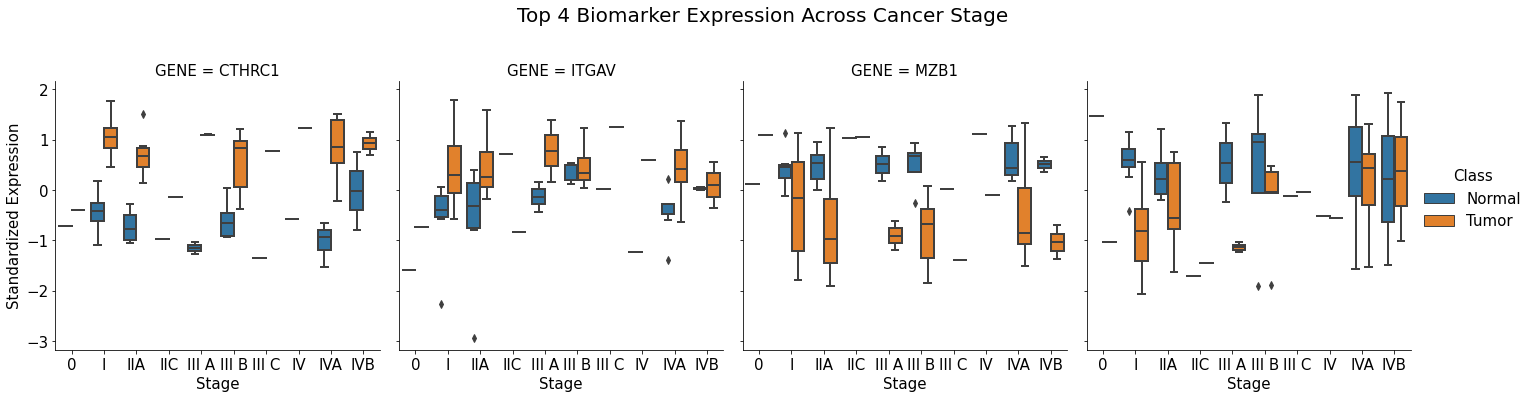

In [1020]:
plt.rcParams['figure.figsize']=(200,500)
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

sns.catplot(data=analysisMelt,x="Stage",y="Standardized Expression",col="GENE",
            hue="Class",kind="box",order=order,linewidth=2)
plt.title('Top 4 Biomarker Expression Across Cancer Stage',loc="center",y=1.2,size=20,x=-1)

## 8.B. Assess the top 4 potential biomarkers across patient ages

Text(-1, 1.2, 'Top 4 Biomarker Expression Across Age')

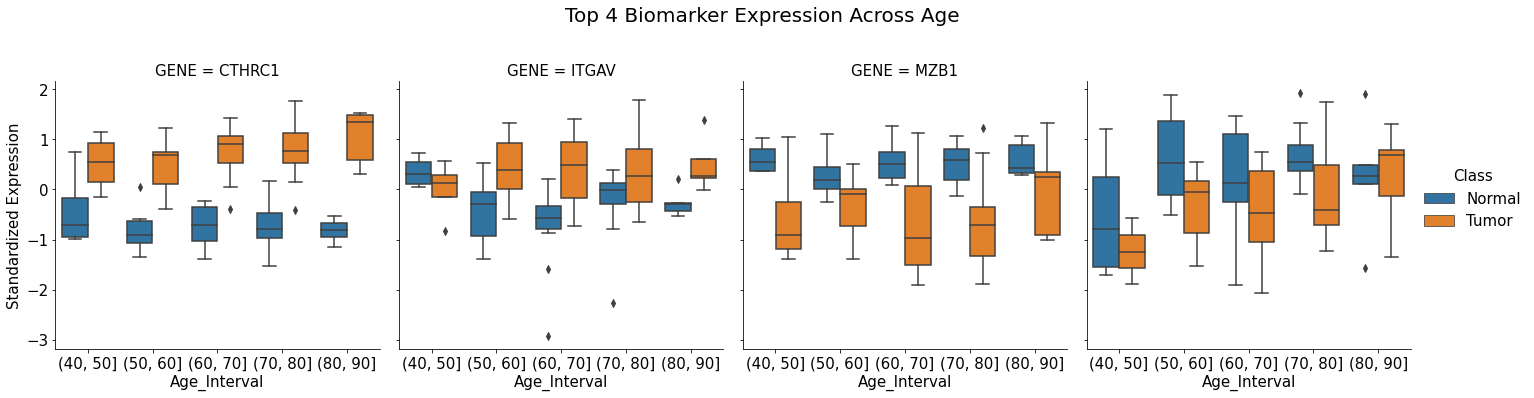

In [1021]:
plt.rcParams['figure.figsize']=(200,500)
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15
sns.catplot(data=analysisMelt,x="Age_Interval",y="Standardized Expression",col="GENE",hue="Class",kind="box")
plt.title('Top 4 Biomarker Expression Across Age',loc="center",y=1.2,size=20,x=-1)

In [871]:
analysisMelt.columns

Index(['Class', 'Age', 'Age_Interval', 'Tumor Content', 'Description', 'Stage',
       'GENE', 'Standardized Expression'],
      dtype='object')

In [979]:
topCands = metaDf.loc[:,markers]
topCands["Class"] = metaDf["Class"]

## 8.C. Assess top biomarker expression across tumor and normal samples

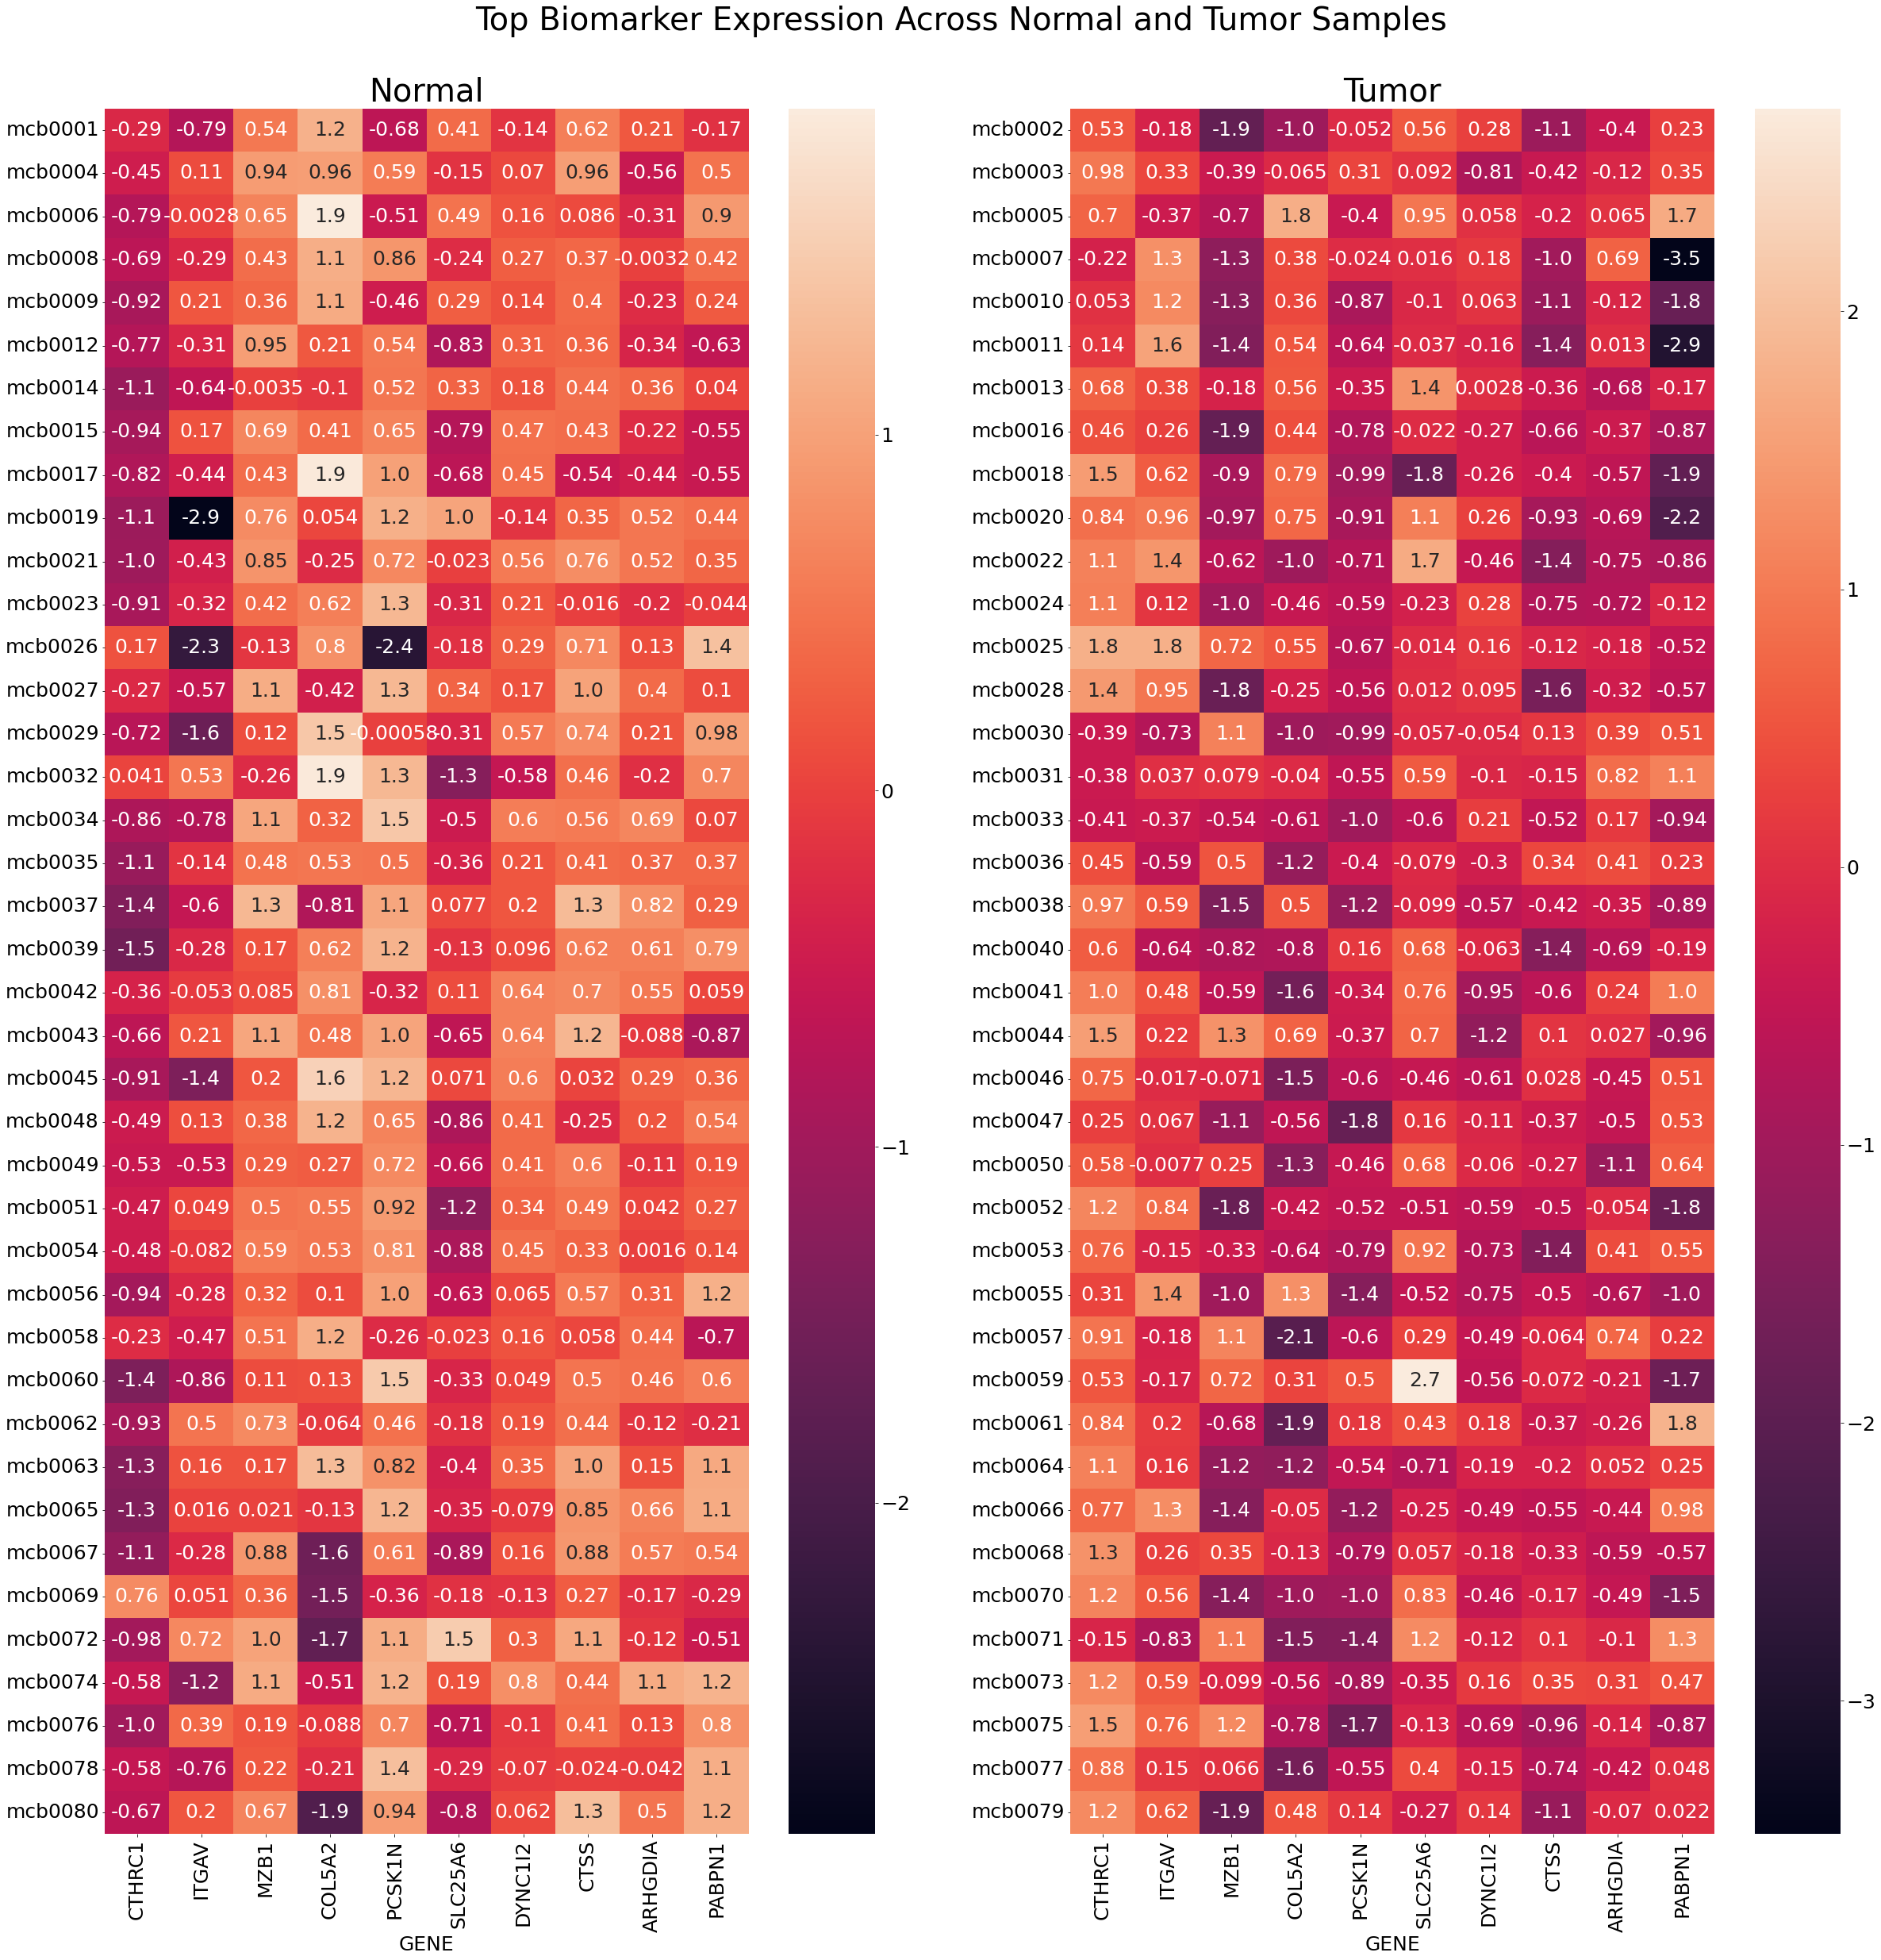

In [1022]:
plt.rcParams['figure.figsize']=(40,40)
plt.rcParams['legend.fontsize'] = 27
plt.rcParams['font.size'] = 25

fig, (ax1,ax2) =plt.subplots(1,2,sharex='col', sharey=False)
fig.suptitle('Top Biomarker Expression Across Normal and Tumor Samples',y=0.925,fontsize=40)
ax1.set_title('Normal',fontsize=40)
ax2.set_title('Tumor',fontsize=40)
sns.heatmap(topCands[topCands["Class"]=="Normal"].iloc[:,:-1], ax=ax1,annot=True,fmt=".2")
sns.heatmap(topCands[topCands["Class"]=="Tumor"].iloc[:,:-1], ax=ax2,annot=True,fmt=".2")

plt.show()

## 8.D. Observe Sample Correlations

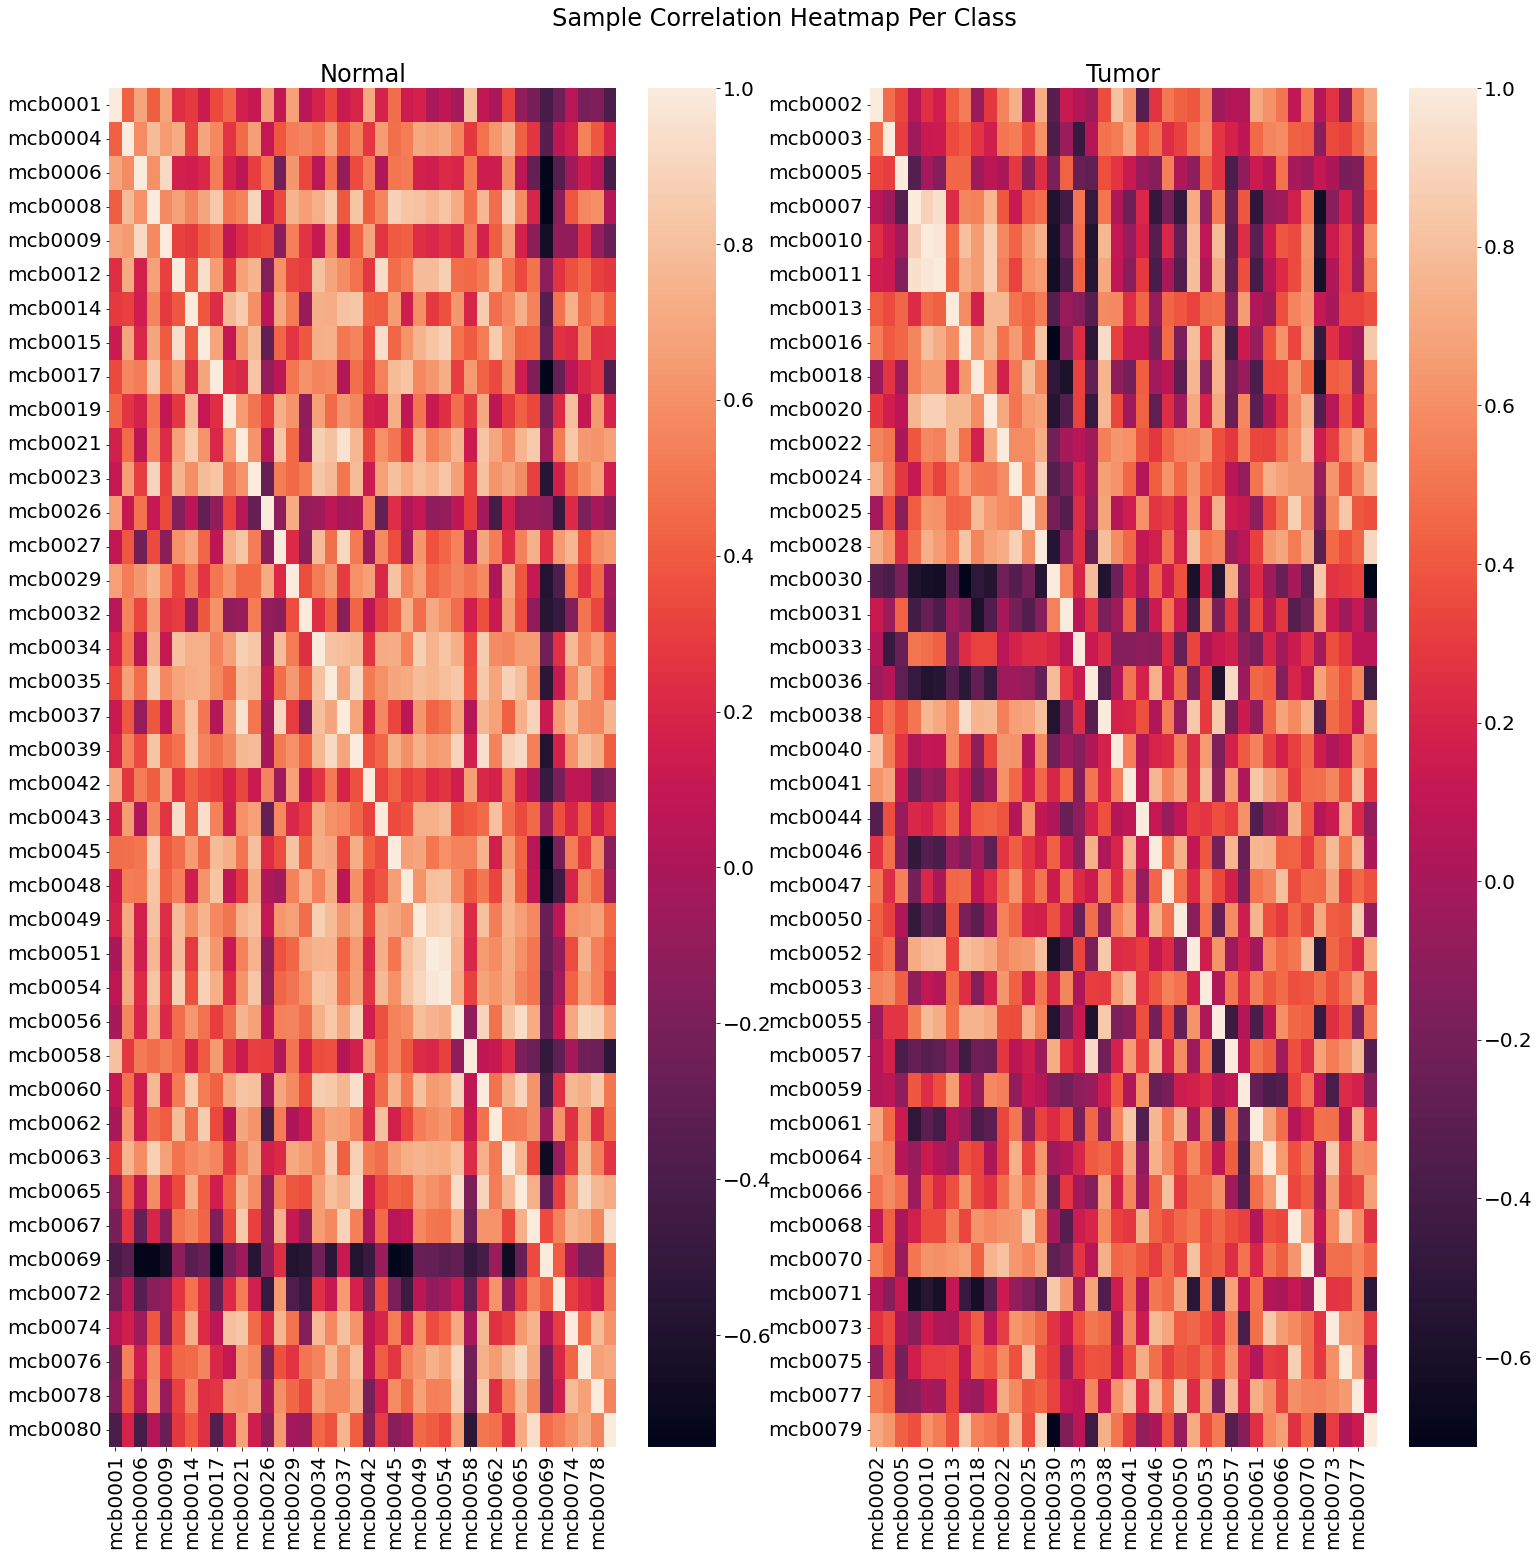

In [982]:
plt.rcParams['figure.figsize']=(25,25)
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['font.size'] = 20

fig, (ax1,ax2) =plt.subplots(1,2,sharex='col', sharey=False)
fig.suptitle('Sample Correlation Heatmap Per Class',y=0.925)
ax1.set_title('Normal')
ax2.set_title('Tumor')
sns.heatmap(topCands[topCands["Class"]=="Normal"].iloc[:,:-1].T.corr(), ax=ax1)
sns.heatmap(topCands[topCands["Class"]=="Tumor"].iloc[:,:-1].T.corr(), ax=ax2)

plt.show()

## 8.E. Top 4 Potential Biomarker Relationships

Text(0.5, 1.08, 'Top 4 Biomarker Relationships')

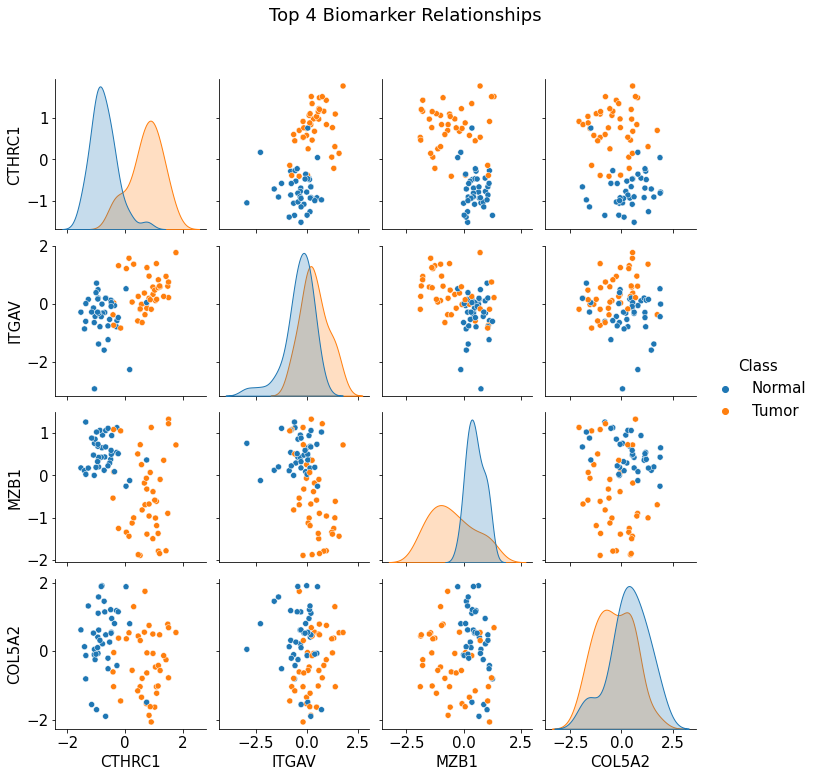

In [997]:
plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 15

top4Markers = topCands.iloc[:,:4]
top4Markers["Class"] = topCands["Class"]

top25Markers=metaDf.loc[:,findBiomarkers(df,25)]
top25Markers["Class"]=metaDf["Class"]


g = sns.pairplot(top4Markers, hue="Class")
g.fig.suptitle("Top 4 Biomarker Relationships", y=1.08)

In [986]:
top25Markers=metaDf.loc[:,findBiomarkers(df,25)]
top25Markers["Class"]=metaDf["Class"]

## 8.F. Top 25 potential biomarker correlations

Text(0.5, 1.0, 'Top 25 Biomarker Correlations')

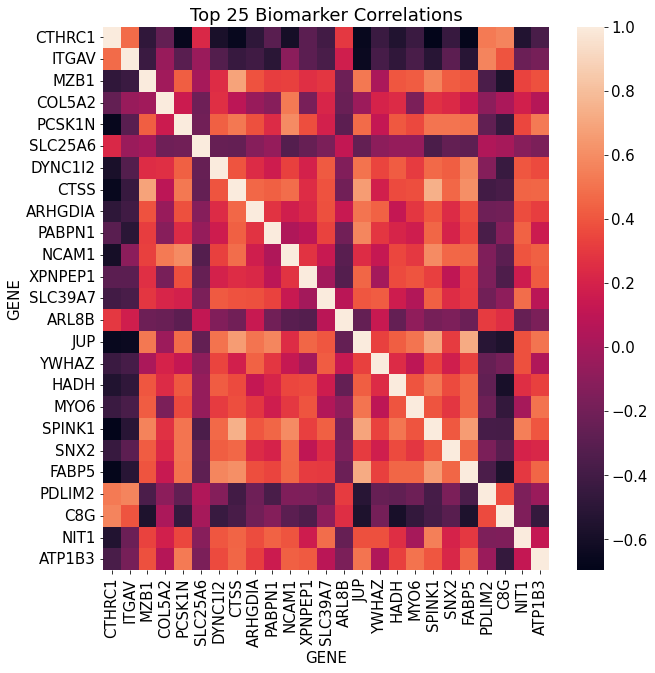

In [1002]:
ax = plt.axes()
sns.heatmap(top25Markers.iloc[:,:-1].corr())
ax.set_title('Top 25 Biomarker Correlations')